<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
#loading graph
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [4]:
df_final_train.head(1)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.0,0.0,0.0,6,15,8,...,0.000002,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,0.000001,6.616550e-14,9.771077e-13,4.159752e-14


In [5]:
#adding preferential attachment score is multiplying neighbors of both the persons
#adar index
def calc_pref_attach_in(a,b):
    try:
#         print(len(set(train_graph.successors(a))))
#         print(len(set(train_graph.successors(b))))
        val = len(set(train_graph.successors(a))) *len(set(train_graph.successors(b)))
        if val!=0:
            return val
        else:
            return 0
    except:
        return 0


## Preferential Attachment

In [6]:
df_final_train['pref_attach'] = df_final_train.apply(lambda row: calc_pref_attach_in(row['source_node'],row['destination_node']),axis=1)
#mapping adar index on test
df_final_test['pref_attach'] = df_final_test.apply(lambda row: calc_pref_attach_in(row['source_node'],row['destination_node']),axis=1)


In [7]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_final_train['pref_attach'] = min_max_scaler.fit_transform(df_final_train['pref_attach'].values.reshape(-1, 1))
df_final_test['pref_attach'] = min_max_scaler.transform(df_final_test['pref_attach'].values.reshape(-1, 1))

D:\Installation\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
pqr

NameError: name 'pqr' is not defined

In [61]:
svd_source_u = [df_final_train['svd_u_s_1'], df_final_train['svd_u_s_2'], df_final_train['svd_u_s_3'], df_final_train['svd_u_s_4'], df_final_train['svd_u_s_5'], df_final_train['svd_u_s_6']]
svd_dest_u = [df_final_train['svd_u_d_1'], df_final_train['svd_u_d_2'], df_final_train['svd_u_d_3'], df_final_train['svd_u_d_4'], df_final_train['svd_u_d_5'], df_final_train['svd_u_d_6']]
svd_source_v = [df_final_train['svd_v_s_1'], df_final_train['svd_v_s_2'], df_final_train['svd_v_s_3'], df_final_train['svd_v_s_4'], df_final_train['svd_v_s_5'], df_final_train['svd_v_s_6']]
svd_dest_v = [df_final_train['svd_v_d_1'], df_final_train['svd_v_d_2'], df_final_train['svd_v_d_3'], df_final_train['svd_v_d_4'], df_final_train['svd_v_d_5'], df_final_train['svd_v_d_6']]


In [62]:
print(len(svd_source_u[0]))
print(len(svd_dest_u[0]))
print(len(svd_source_v[0]))
print(len(svd_dest_v[0]))



100002
100002
100002
100002


In [63]:
# https://stackoverflow.com/questions/30382018/np-einsum-vs-np-dot-giving-different-results
# print(len(np.einsum('ij,ij->j', svd_source_u, svd_dest_u)))
df_final_train['svd_dot_u'] = np.einsum('ij,ij->j', svd_source_u, svd_dest_u)
# print(len())
df_final_train['svd_dot_v']=np.einsum('ij,ij->j', svd_source_v, svd_dest_v)


In [64]:
svd_source_u = [df_final_test['svd_u_s_1'], df_final_test['svd_u_s_2'], df_final_test['svd_u_s_3'], df_final_test['svd_u_s_4'], df_final_test['svd_u_s_5'], df_final_test['svd_u_s_6']]
svd_dest_u = [df_final_test['svd_u_d_1'], df_final_test['svd_u_d_2'], df_final_test['svd_u_d_3'], df_final_test['svd_u_d_4'], df_final_test['svd_u_d_5'], df_final_test['svd_u_d_6']]
svd_source_v = [df_final_test['svd_v_s_1'], df_final_test['svd_v_s_2'], df_final_test['svd_v_s_3'], df_final_test['svd_v_s_4'], df_final_test['svd_v_s_5'], df_final_test['svd_v_s_6']]
svd_dest_v = [df_final_test['svd_v_d_1'], df_final_test['svd_v_d_2'], df_final_test['svd_v_d_3'], df_final_test['svd_v_d_4'], df_final_test['svd_v_d_5'], df_final_test['svd_v_d_6']]


In [65]:
# https://stackoverflow.com/questions/30382018/np-einsum-vs-np-dot-giving-different-results
# print(len(np.einsum('ij,ij->j', svd_source_u, svd_dest_u)))
df_final_test['svd_dot_u'] = np.einsum('ij,ij->j', svd_source_u, svd_dest_u)
# print(len())
df_final_test['svd_dot_v']=np.einsum('ij,ij->j', svd_source_v, svd_dest_v)


In [51]:
# df_final_test['svd_dot_u_1'] = df_final_test['svd_u_s_1'] * df_final_test['svd_u_d_1']
# df_final_test['svd_dot_u_2'] = df_final_test['svd_u_s_2'] * df_final_test['svd_u_d_2']
# df_final_test['svd_dot_u_3'] = df_final_test['svd_u_s_3'] * df_final_test['svd_u_d_3']
# df_final_test['svd_dot_u_4'] = df_final_test['svd_u_s_4'] * df_final_test['svd_u_d_4']
# df_final_test['svd_dot_u_5'] = df_final_test['svd_u_s_5'] * df_final_test['svd_u_d_5']
# df_final_test['svd_dot_u_6'] = df_final_test['svd_u_s_6'] * df_final_test['svd_u_d_6']


In [52]:
# df_final_train['svd_dot_u_1'] = df_final_train['svd_u_s_1'] * df_final_train['svd_u_d_1']
# df_final_train['svd_dot_u_2'] = df_final_train['svd_u_s_2'] * df_final_train['svd_u_d_2']
# df_final_train['svd_dot_u_3'] = df_final_train['svd_u_s_3'] * df_final_train['svd_u_d_3']
# df_final_train['svd_dot_u_4'] = df_final_train['svd_u_s_4'] * df_final_train['svd_u_d_4']
# df_final_train['svd_dot_u_5'] = df_final_train['svd_u_s_5'] * df_final_train['svd_u_d_5']
# # df_final_train['svd_dot_u_6'] = df_final_train['svd_u_s_6'] * df_final_train['svd_u_d_6']


In [66]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_attach', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [67]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_attach', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [68]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [69]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9128093143379071 test Score 0.9003502069404649
Estimators =  50 Train Score 0.919392168567449 test Score 0.914649520927887
Estimators =  100 Train Score 0.9194221575990877 test Score 0.9141969607925446
Estimators =  250 Train Score 0.921380953376105 test Score 0.9165547910723276
Estimators =  450 Train Score 0.9219604521546362 test Score 0.917014800041986


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

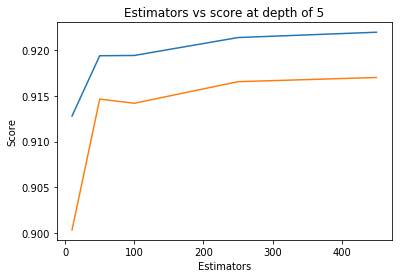

In [70]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.882871311104326 test Score 0.8626248767311236
depth =  9 Train Score 0.9567402987514558 test Score 0.9228852569787576
depth =  11 Train Score 0.9598402575439597 test Score 0.9239729062480219
depth =  15 Train Score 0.9634670268842869 test Score 0.9264284510365751
depth =  20 Train Score 0.9632966096536613 test Score 0.9258386295719516
depth =  35 Train Score 0.9632726792981318 test Score 0.926099039919151
depth =  50 Train Score 0.9632726792981318 test Score 0.926099039919151
depth =  70 Train Score 0.9632726792981318 test Score 0.926099039919151
depth =  130 Train Score 0.9632726792981318 test Score 0.926099039919151


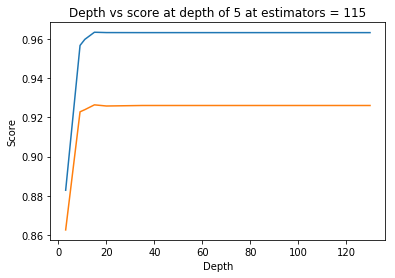

In [71]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [72]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96162089 0.9618011  0.9597477  0.96143249 0.96284694]
mean train scores [0.96270231 0.96247964 0.96014108 0.96222759 0.96395495]


In [73]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [74]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [75]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [76]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.964000691316857
Test f1 score 0.9264547697888764


In [77]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


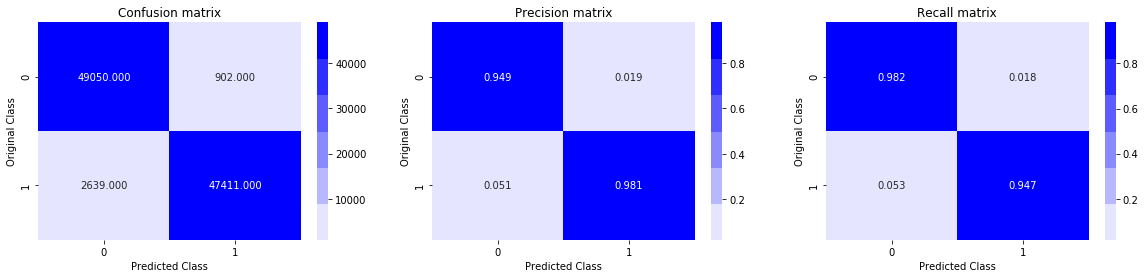

Test confusion_matrix


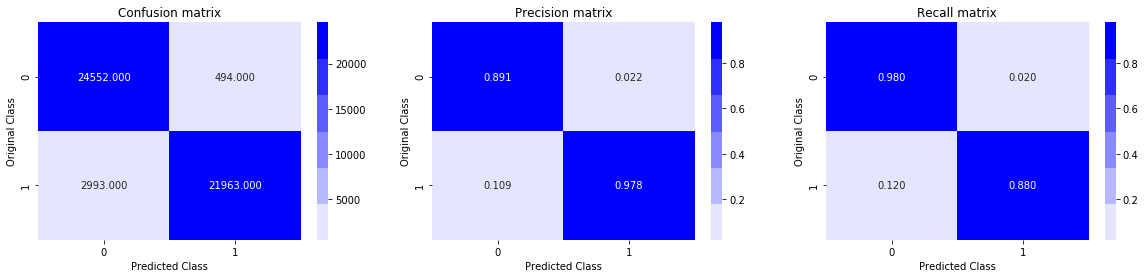

In [78]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

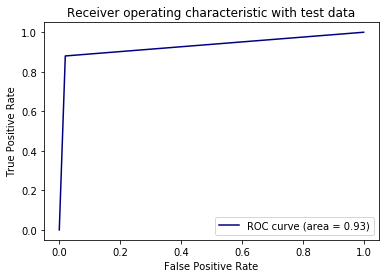

In [79]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

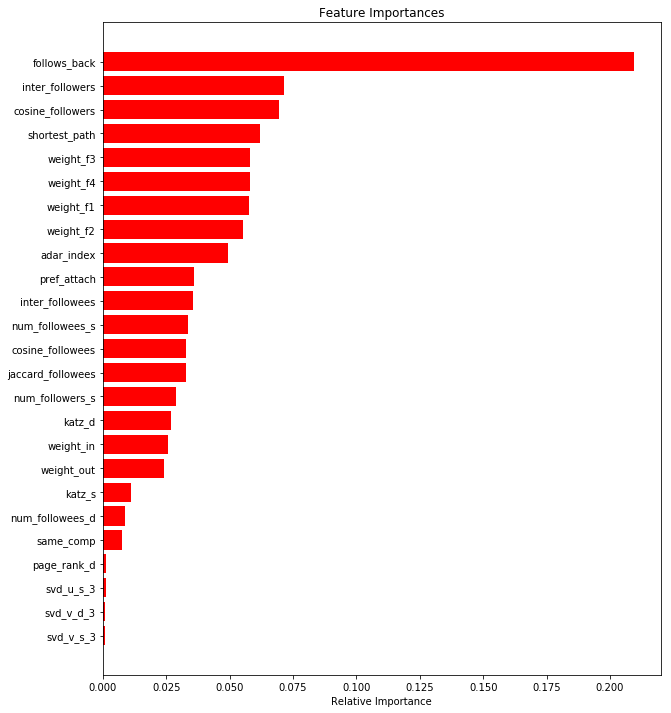

In [80]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [81]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attach,svd_dot_u,svd_dot_v
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,0.001429,1.114958e-11,2.238775e-12
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,0.103119,3.192812e-03,9.068719e-04
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,0.010738,1.787503e-35,2.467873e-36
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,0.000417,4.710376e-20,3.159386e-18
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000393,7.773952e-14,0.000000e+00


In [82]:
from sklearn.model_selection import RandomizedSearchCV 

params = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6],
 'n_estimators': [100, 200, 300, 400]
}
gsearch2 = RandomizedSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_distributions = params, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(df_final_train,y_train)
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
          fit_params=None, iid=False, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6], 'n_estimators': [100, 200, 300, 400]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [83]:
y_train_pred = gsearch2.predict(df_final_train)
y_test_pred = gsearch2.predict(df_final_test)


In [84]:
train_sc = f1_score(y_train,y_train_pred)
print(train_sc)
test_sc = f1_score(y_test,y_test_pred)
print(test_sc)

0.9973390420551398
0.9211538461538461


#### Conclusion: We are getting 92 percent accuracy on test data.